## UMAP distribution analysis

In this notebook, we analyze the chemical space coverage of our algorithm.   
We compare the chemical space coverage of ZINC molecules that are 'parents' of our fragments and the molecules randomly generated from the fragments. Three fragment libraries are analyzed - n=91 library we used in the main experiments, the same n=91 library but when all possible attachment sites are included in fragments, and n=1k library. 

In [5]:
import pandas as pd 
from rdkit import Chem
import glob

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops

import numpy as np
import umap.umap_ as umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In /home/crystal/anaconda3/envs/freed_pt/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/crystal/anaconda3/envs/freed_pt/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/crystal/anaconda3/envs/freed_pt/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/crystal/anaconda3/envs/freed_pt/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [3]:
import base64
from io import BytesIO
from bokeh.io import output_notebook, output_file
from bokeh.plotting import ColumnDataSource, figure, show, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
from bokeh.resources import INLINE
output_notebook(INLINE)

from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

Loading BokehJS ...

In [6]:
def ExplicitBitVect_to_NumpyArray(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))
    
def im_2_b64(image):
    buff = BytesIO()
    image.save(buff, format="JPEG")
    img_str = base64.b64encode(buff.getvalue())
    return "data:image/png;base64,"+img_str.decode()

Open the ZINC molecule set (n=2.5k) we used to generate the fragment library. 

In [9]:
zinc = open('2.5k_rndm_zinc_drugs_clean.smi','r').readlines()
zinc = [z.strip('\n') for z in zinc]
zinc_mol = [Chem.MolFromSmiles(z) for z in zinc]
zinc_canon = [Chem.MolToSmiles(m) for m in zinc_mol]

In [10]:
zinc_dict = {'smi': zinc_canon, 'mol':zinc_mol}
zinc_df = pd.DataFrame.from_dict(zinc_dict)

Load the molecules our model randomly generated with n=91 fragment library. 

In [11]:
gen_91 = glob.glob(f'random_gen_91.csv')

In [12]:
gen_91_smis = []
gen_91_mols = []
gen_91_canon = []
for gen in gen_91:
    gen_91_smi = open(gen, 'r').readlines()
    gen_91_smi = [g.split(',')[0] for g in gen_91_smi]
    gen_91_smis.extend(gen_91_smi)
gen_91_mols = [Chem.MolFromSmiles(s) for s in gen_91_smis]
gen_91_canon = [Chem.MolToSmiles(m) for m in gen_91_mols]

In [14]:
gen_91_dict = {'smi': gen_91_canon, 'mol':gen_91_mols}
gen_91_df = pd.DataFrame.from_dict(gen_91_dict)

Load the molecules our model randomly generated with the fragment library that includes the same fragments with the n=91 fragment library, but this time the fragments have all possible attachment sites. 

In [17]:
gen_91_all_att = glob.glob(f'random_gen_91_all_att.csv')

In [18]:
gen_91_all_att_smis = []
gen_91_all_att_mols = []
gen_91_all_att_canon = []
for gen in gen_91_all_att:
    gen_91_all_att_smi = open(gen, 'r')
    gen_91_all_att_smi = [g.split(',')[0] for g in gen_91_all_att_smi]
    gen_91_all_att_smis.extend(gen_91_all_att_smi)

In [19]:
gen_91_all_att_mols = [Chem.MolFromSmiles(s) for s in gen_91_all_att_smis]
gen_91_all_att_canon = []
for m in gen_91_all_att_mols:
    try:
        gen_91_all_att_canon.append(Chem.MolToSmiles(m))
    except:
        gen_91_all_att_canon.append(None)

In [20]:
gen_91_all_att_dict = {'smi': gen_91_all_att_canon, 'mol':gen_91_all_att_mols}
gen_91_all_att_df = pd.DataFrame.from_dict(gen_91_all_att_dict)
gen_91_all_att_df = gen_91_all_att_df.dropna()

Load the molecules our model randomly generated with the n=1k fragment library. 

In [21]:
gen_1k = glob.glob(f'random_gen_1k.csv')

In [22]:
gen_1k_smis = []
gen_1k_mols = []
gen_1k_canon = []
for gen in gen_1k:
    gen_1k_smi = open(gen, 'r').readlines()
    gen_1k_smi = [g.split(',')[0] for g in gen_1k_smi]
    gen_1k_smis.extend(gen_1k_smi)

In [23]:
gen_1k_mols = [Chem.MolFromSmiles(s) for s in gen_1k_smis]
gen_1k_canon = []
for m in gen_1k_mols:
    try:
        gen_1k_canon.append(Chem.MolToSmiles(m))
    except:
        gen_1k_canon.append(None)

In [24]:
gen_1k_dict = {'smi': gen_1k_canon, 'mol':gen_1k_mols}
gen_1k_df = pd.DataFrame.from_dict(gen_1k_dict)
gen_1k_df = gen_1k_df.dropna()

In [25]:
gen_91_df = gen_91_df.drop_duplicates(subset=['smi'])
gen_1k_df = gen_1k_df.drop_duplicates(subset=['smi'])
gen_91_all_att_df = gen_91_all_att_df.drop_duplicates(subset=['smi'])

In [26]:
print(len(gen_91_df))
print(len(gen_1k_df))
print(len(gen_91_all_att_df))

9747
9349
9423


Perform UMAP on molecular fingerprints of the generated molecules and ZINC molecules. 

In [27]:
reducer = umap.UMAP()

gen_91_df['type'] = 'lib_91'
gen_1k_df['type'] = 'lib_1k'
gen_91_all_att_df['type'] = 'lib_all_att'
zinc_df['type'] = 'zinc'

tot_mol = pd.concat([gen_91_df, gen_1k_df, gen_91_all_att_df, zinc_df])
tot_mol.dropna(inplace=True)
tot_mol['morganFP'] = tot_mol['mol'].apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, 2))
tot_mol['morganFP'] = tot_mol['morganFP'].apply(ExplicitBitVect_to_NumpyArray)

scaled_smiles = np.stack(tot_mol['morganFP'].values)
embedding = reducer.fit_transform(scaled_smiles)

## Plots

**Blue: n=91, Orange: n=1k, Green: n=91 with all attachment sites, Red: ZINC reference molecules**

First, let's plot everything in one figure. 

In [28]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in tot_mol.type.map({"lib_91":0, "lib_1k":1, "lib_all_att":2, "zinc":3})], s=0.2)
plt.gca().set_aspect('equal', 'datalim')

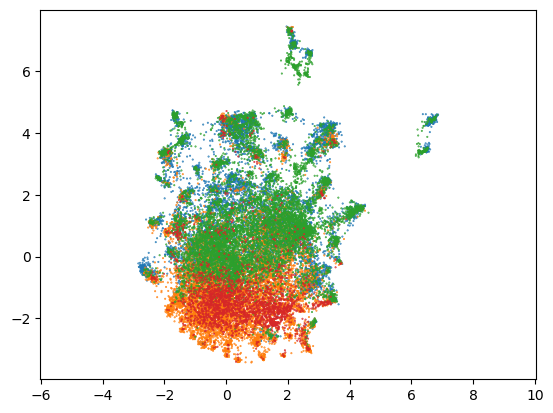

In [29]:
plt.show()

In [30]:
plt.clf()

From the figure above, we can observe that the chemical space that ZINC reference molecules occupy is mostly covered by n=1k fragment library, and half-covered by n=91 libraries. 

Let's observe the result one by one.

### n=91 vs. ZINC

In [31]:
cnt_mol = pd.concat([tot_mol.iloc[:9747], tot_mol.iloc[-2500:]])
plt.scatter(
    np.append(embedding[:9747, 0], embedding[-2500:, 0]),
    np.append(embedding[:9747, 1], embedding[-2500:, 1]),
    c=[sns.color_palette()[x] for x in cnt_mol.type.map({"lib_91":0, "lib_1k":1, "lib_all_att":2, "zinc":3})], s=0.2)
plt.gca().set_aspect('equal', 'datalim')

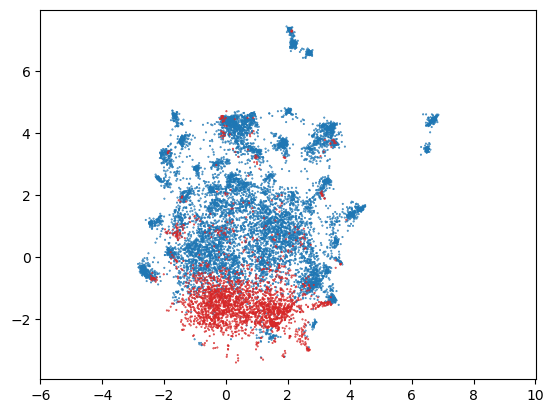

In [32]:
plt.show()

In [34]:
plt.clf()

The n=91 fragment library was able to cover about the half of the ZINC reference molecules. 

### n=1k vs. ZINC

In [33]:
9349 + 9747

19096

In [34]:
cnt_mol = pd.concat([tot_mol.iloc[9747:19096], tot_mol.iloc[-2500:]])
plt.scatter(
    np.append(embedding[9747:19096, 0], embedding[-2500:, 0]),
    np.append(embedding[9747:19096, 1], embedding[-2500:, 1]),
    c=[sns.color_palette()[x] for x in cnt_mol.type.map({"lib_91":0, "lib_1k":1, "lib_all_att":2, "zinc":3})], s=0.2)
plt.gca().set_aspect('equal', 'datalim')

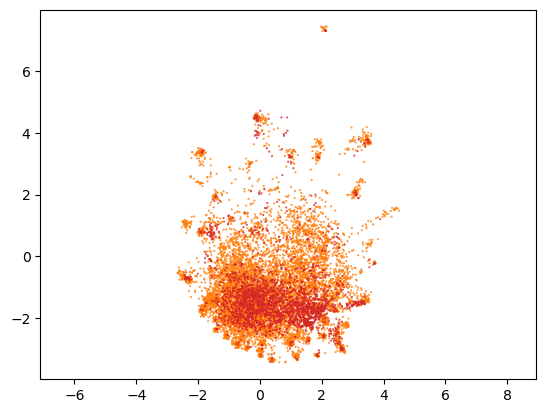

In [35]:
plt.show()

In [36]:
plt.clf()

The n=1k fragment library was able to cover most of the ZINC reference molecules. Moreover, the library was able to cover extended area in the chemical space. 

### n=91 w/ all attachment sites vs. ZINC

In [37]:
cnt_mol = pd.concat([tot_mol.iloc[25775:-2500], tot_mol.iloc[-2500:]])
plt.scatter(
    np.append(embedding[25775:-2500, 0], embedding[-2500:, 0]),
    np.append(embedding[25775:-2500, 1], embedding[-2500:, 1]),
    c=[sns.color_palette()[x] for x in cnt_mol.type.map({"lib_91":0, "lib_1k":1, "lib_all_att":2, "zinc":3})], s=0.2)
plt.gca().set_aspect('equal', 'datalim')

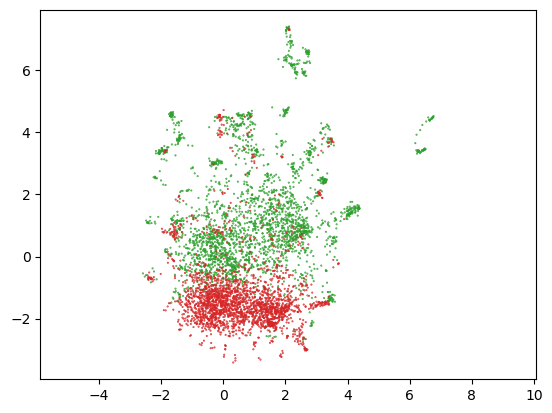

In [38]:
plt.show()

The n=91 fragment library with all attachment sites was able to cover about the half of the ZINC reference molecules. Compared to the original n=91 fragment library, 